# City Lines Data Analysis

> This notebook was created as part of the examination requirements of "Information Structures and Implications" class offered by the Master of Digital Humanities programme in KU Leuven. Some code cells (DB setup, visualization presets, visualization code) are collapsed to offer a better reading experience.

## What's this notebook about?

Often times it is thought that the complexity level of a city's transportation systems is linked to that city's level of "development". We want to investigate whether this widely-held belief holds true by interrogating the city lines dataset and combining it with other datasets which can inform us about human development. While doing this, we also want to uncover some less-known facts about metro systems such as dominant colors and crowdedness.

The questions that we will ask are as follows: 

1. ***Is the education level of a country related to its total railway length?***
2. ***Is the subjective well-being of a country related to its total railway length?***
3. ***Is mobile phone ownership related to the variety of transportation modes in a country?***
4. ***Are freedom of speech scores related to the variety of transportation modes in a country?***
5. ***What is the average station completion time for each city?***
6. ***Are there any “late bloomer” cities? Cities that started building up their metro system late but have quickly built up many lines and stations.***
7. ***What are the most “crowded” (short line, lots of stations) and the most “spacious” (long line, barely no stations) lines?***
8. ***What are some unique colors that nobody uses in coloring their metro lines?***
9. ***Is there a correlation between the age of a line and its color?***
10. ***What is the most dominant line color for each country?***

In line with our initial prompt, the questions we ask can be partitioned into two groups. Questions one to four (inclusive) make up the first group of questions related to development and transportation systems. The rest of the questions (five to ten) give insights about some lesser-known facts that are not easily revealed unless explicity asked for.

## Code

### Setup

The child cells of this cell are collapsed to allow for a better reading experience.

#### Import the required packages

In [2]:
from pathlib import Path
import mysql.connector as connector
import numpy as np
import pandas as pd
import colour
import skimage.color
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


#### Establish connection with the database

In [3]:
credentials = {
    "username": "root",
    "password": ""
}

conn = connector.connect(user=credentials["username"],
                         passwd=credentials["password"],
                         host="localhost",
                         database="city_lines")

#### Configure visualization presets and define helper functions

In [4]:
# Figure
mpl.rcParams["figure.facecolor"] = "1A1C1A"
mpl.rcParams["figure.edgecolor"] = "1A1C1A"

# Axes
mpl.rcParams["axes.facecolor"] = "1A1C1A"
mpl.rcParams["axes.edgecolor"] = "DBDDDB"
mpl.rcParams["axes.labelcolor"] = "DBDDDB"

# Ticks
mpl.rcParams["xtick.color"] = "DBDDDB"
mpl.rcParams["ytick.color"] = "DBDDDB"

# Typography
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "DBDDDB"

# Helper functions
def add_value_labels_barh(ax, bar,
                          l_prefix="", l_suffix="",
                          fontsize=12, fontweight="normal", fcolors=["white", "black"],
                          ha="center", va="center_baseline", rotation=0):

    for patch in bar.patches:
        # Get raw label and placement data
        value = patch.get_width()
        height = patch.get_height()
        width = patch.get_width()
        x = patch.get_x()
        y = patch.get_y()
        avg_brightness = sum(patch.get_facecolor()[0:3]) / 3

        # Calculate where to put the label
        # label_x = x + width / 2
        label_x = x + width / 2
        label_y = y + height / 2

        # Use Y value as label and format number with one decimal place
        label = "{}{:.1f}{}".format(l_prefix, value, l_suffix) #Remove .1f if you don't want one decimal place

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (label_x, label_y),         # Set initial label location
            xytext=(0, 0),              # Shift label by using `space` as padding
            xycoords=("data"),
            textcoords="offset points", # Interpret `xytext` as offset in points
            fontsize=fontsize,
            fontweight=fontweight,
            color=fcolors[0] if avg_brightness < 0.50 else fcolors[1],
            ha=ha,                      # Horizontal alignment
            va=va,                      # Vertical alignment
            rotation=rotation           # Degree of rotation
            )      


### Analysis

#### Question three

> ***Is mobile phone ownership related to the variety of transportation modes in a country?***

##### English explanation

###### SQL explanation

Join the 'cities' table with 'mobile_phone_usage' and 'lines' table. Use the 'lines' table as a bridge to join the 'transport_modes'table. Select country names from the 'cities' table, group by that column. Count the distinct number of transport modes in a country as tr_mode_variation, exclude rows with the 'transport modes' value as 0 because 0 is just the generic transport mode id. Also get the information of mobile lines per hundred people from the transport_modes table. Order by transport mode variation in a descending manner.

##### Code

In [5]:
sql_query = """
SELECT c.country,
       COUNT(DISTINCT(l.transport_mode_id)) AS tr_mode_variation, 
       m.lines_per_hundred
  FROM cities c
       JOIN mobile_phone_usage m ON (c.country = m.country)
       JOIN `lines` l ON (c.id = l.city_id)
       JOIN transport_modes tm on (l.transport_mode_id = tm.id )
 WHERE tm.id != 0
 GROUP BY c.country
 ORDER BY tr_mode_variation DESC;
"""

result = pd.read_sql(sql_query, conn)
result

,country,tr_mode_variation,lines_per_hundred
0,France,7,114.20
1,United States,7,103.10
2,Chile,7,122.90
3,Mexico,6,90.20
4,Argentina,4,141.34
5,Brazil,4,141.30
6,Japan,4,115.20
7,Australia,3,87.60
8,Singapore,2,150.10
9,Italy,2,147.40


##### Interpretation of results

###### Visualization

The code responsible for the visualization has been collapsed for ease of reading.

Text(-0.4, 148, "Spearman's rho: -0.46")

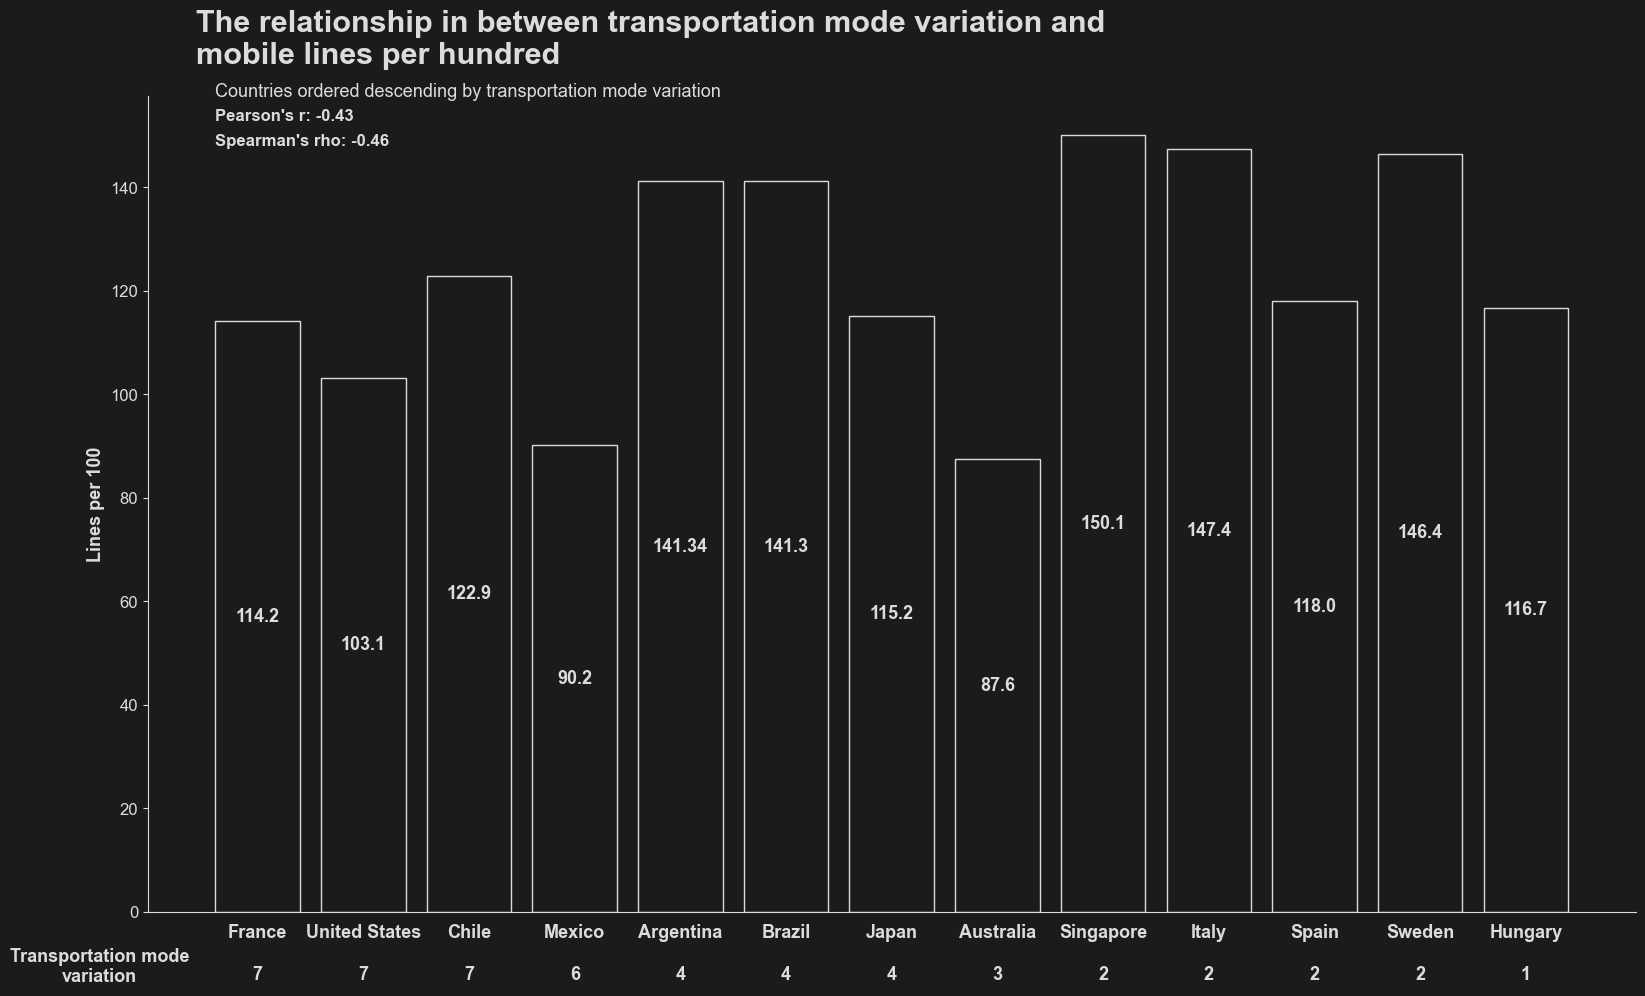

In [6]:
# --- data prep ---
data = result.loc[:, ["tr_mode_variation", "lines_per_hundred"]]
bar_labels = result.loc[:,"country"].values
bar_positions = [i for i in bar_labels]
bar_height = data.loc[:, "lines_per_hundred"]
rcorr = result.corr(method="pearson")
rhocorr = result.corr(method="spearman")

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# configure params
# titles
plt.figtext(s="The relationship in between transportation mode variation and\nmobile lines per hundred",
          x=0.15,
          y=0.91,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

plt.figtext(s="Countries ordered descending by transportation mode variation",
             x=0.16,
             y=0.88,
             va="baseline",
             ha="left",
             fontsize=13,
             fontweight="normal")

# axis labels
ax.set_ylabel("Lines per 100",
              fontsize=13,
              fontweight="bold")

plt.figtext(s="Transportation mode\nvariation",
             x=0.10,
             y=0.06,
             va="baseline",
             ha="center",
             fontsize=13,
             fontweight="bold")

# spines and axes
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# --- plotting ---
bar = ax.bar(x=bar_positions,
            height=bar_height,
            color="#FFFFFF00",
            edgecolor="#DBDDDB", linewidth=1)

# ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels=[bar_label + "\n\n" + rank for bar_label, rank in zip(bar_labels, data["tr_mode_variation"].astype(str).values)],
                   fontsize=13,
                   fontweight="bold")

ax.tick_params(axis = "x",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# bar annotation
ax.bar_label(bar, labels=bar_height, label_type="center",
             fontsize=13, fontweight="bold")

ax.text(x=-0.4, y=153,
        s="Pearson's r: " + "{:.2f}".format(rcorr.values[0][1]),
        va="baseline",
        ha="left",
        fontweight="bold")

ax.text(x=-0.4, y=148,
        s="Spearman's rho: " + "{:.2f}".format(rhocorr.values[0][1]),
        va="baseline",
        ha="left",
        fontweight="bold")

###### Interpretation

The bar chart above displays the mobile lines owned per hundred people for thirteen countries in the dataset that had information present about mobile phone prevalence. The countries are ordered descending by transport mode variation and the annotation below the country name shows the transportation mode variation for each country. **A subtle and very weak trend can be noticed in between transportation mode variation and mobile phone ownership per 100 people. These two variables are very weakly negatively correlated** (r = -0.43, rho = 0.46), **meaning that as transportation mode variation decreases, the number of lines owned per 100 people increases** and vice versa. **However, this finding can be ignored on the grounds that the sample subset is too small of a subset of all countries in the dataset and that the relationship observed is very weak overall.**

#### Question five

> ***What is the average station completion time for each city?***

##### English explanation

###### SQL explanation

Join the 'cities' table with the 'station's table. Select and group by city names. For each city, calculate the average time between station opening dates and station building start dates. Take that calculated value as average construction duration. To filter out problematic data, select rows whose avg_const_dur is above zero (a station cannot take negative days/years to complete) and not NaN. Sort by ascending average construction duration.

##### Code

In [7]:
sql_query = """
SELECT c.name, AVG(((s.opening - s.buildstart))) AS avg_const_dur
  FROM cities c
       JOIN stations s ON (c.id = s.city_id)
 GROUP BY c.name
 HAVING avg_const_dur NOT LIKE "NaN"
        AND avg_const_dur > 0
 ORDER BY avg_const_dur ASC;
"""

result = pd.read_sql(sql_query, conn)

##### Interpretation of results

###### Visualization

The code responsible for creating the visualization has been collapsed for ease of reading.

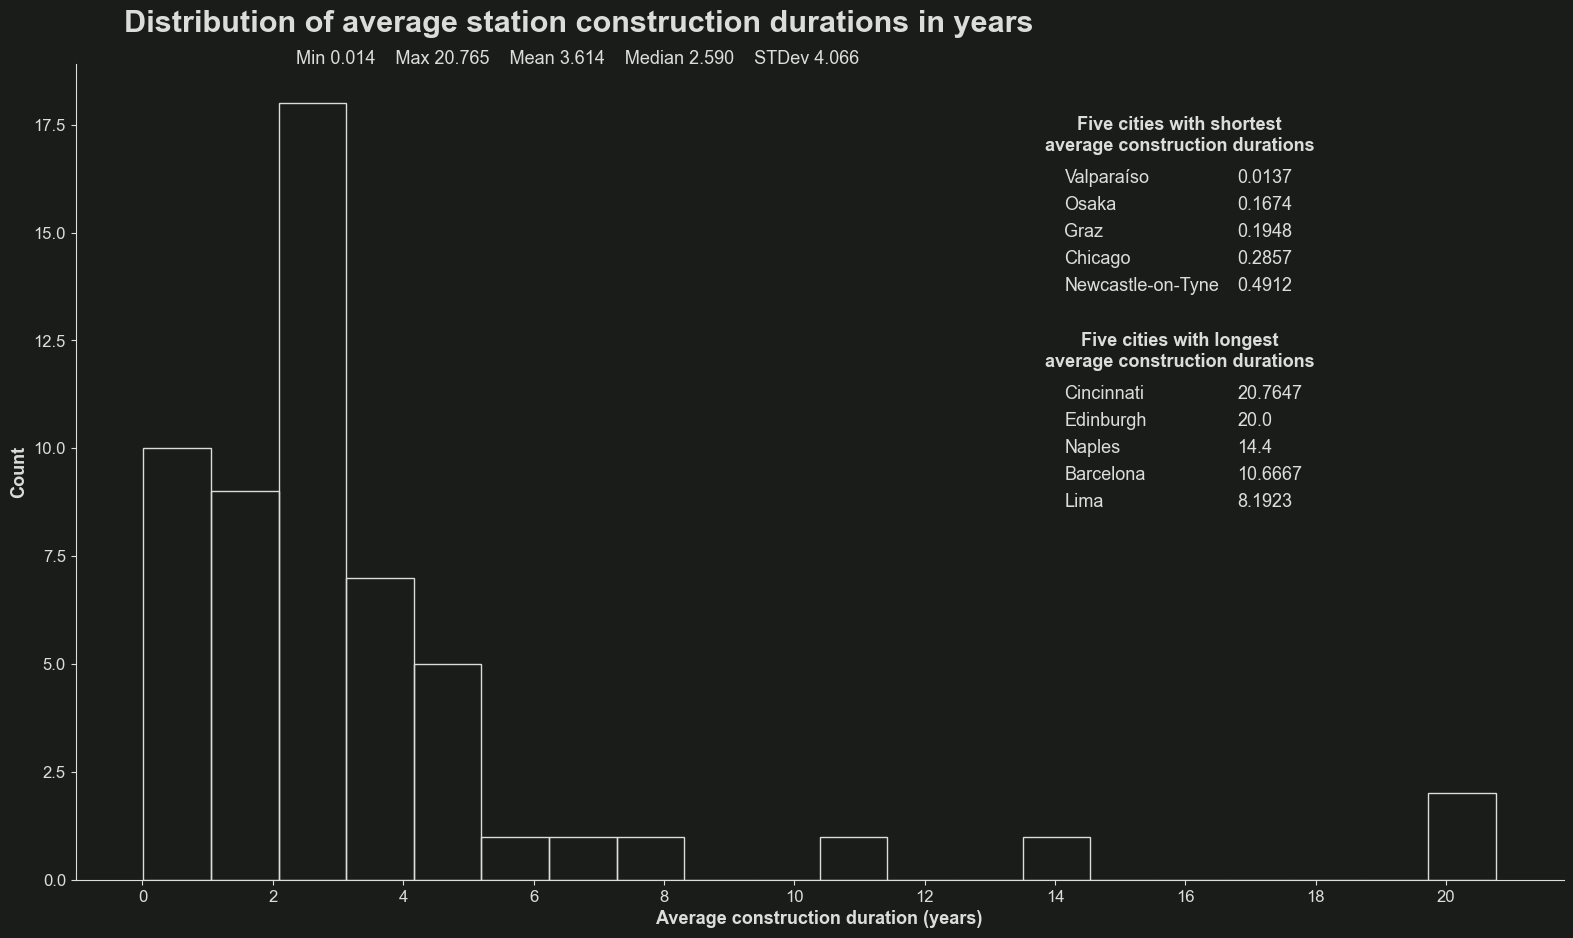

In [8]:
# --- data prep ---
data = result
s_stat = {
    "min": "{:.3f}".format(result["avg_const_dur"].min()),
    "max": "{:.3f}".format(result["avg_const_dur"].max()),
    "mean": "{:.3f}".format(result["avg_const_dur"].mean()),
    "median": "{:.3f}".format(result["avg_const_dur"].median()),
    "stdev": "{:.3f}".format(result["avg_const_dur"].std()),
}

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# configure params
# titles
plt.figtext(s="Distribution of average station construction durations in years",
          x=0.15,
          y=0.91,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# Annotation
plt.figtext(s=(("Min {}    "
                "Max {}    "
                "Mean {}    "
                "Median {}    "
                "STDev {}    ")
                .format(s_stat["min"], s_stat["max"], s_stat["mean"],
                        s_stat["median"], s_stat["stdev"])),
             x=0.24,
             y=0.88,
             va="baseline",
             ha="left",
             fontsize=13,
             fontweight="normal")

plt.figtext(s="Five cities with shortest\naverage construction durations",
          x=0.70,
          y=0.80,
          va="baseline",
          ha="center",
          fontsize=13,
          fontweight="bold")


i = 0.77
j = 0.64
for row in result.iloc[:5, :].values:
    name, num = row[0], row[1]
    for col in (name, num):
        plt.figtext(s="{}".format(col),
            x=j,
            y=i,
            va="baseline",
            ha="left",
            fontsize=13,
            fontweight="normal")
        j += 0.09
    i -= 0.025
    j = 0.64

plt.figtext(s="Five cities with longest\naverage construction durations",
          x=0.70,
          y=0.60,
          va="baseline",
          ha="center",
          fontsize=13,
          fontweight="bold")
    
i = 0.57
for row in result.sort_values(by="avg_const_dur", axis=0, ascending=False).iloc[:5, :].values:
    name, num = row[0], row[1]
    for col in (name, num):
        plt.figtext(s="{}".format(col),
            x=j,
            y=i,
            va="baseline",
            ha="left",
            fontsize=13,
            fontweight="normal")
        j += 0.09
    i -= 0.025
    j = 0.64

# axis labels
ax.set_ylabel("Count",
              fontsize=13,
              fontweight="bold")

ax.set_xlabel("Average construction duration (years)",
              fontsize=13,
              fontweight="bold")

# spines and axes
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# # ticks and labels
ax.set_xticks([i for i in range(0, 21, 2)])

# # --- plotting ---
hist = ax.hist(x=result["avg_const_dur"],
               bins=20,
               histtype="bar",
               color="#FFFFFF00",
               edgecolor="#DBDDDB")

###### Interpretation

The distribution of average construction duration in years is heavily skewed to the right with a standart deviation of approximately 4.06 years. Our analysis shows that the mean average construction duration of a metro station is approximately 3.6 years. While this number seems sensible, the minimum and the maximum construction durations does not make any sense. According to the dataset, the record for constructing a station in the shortest amount of days is held by Valparaiso, Chile with approximately five days (0.0137 years). On the contrary, the sad record for taking the most time to construct a station is held by Cincinatti, USA with approximately twenty years and six months.

#### Question eight

> ***What are some unique colors that nobody uses in coloring their metro lines?***

This can be tackled in two ways:
- Comparing hex code colors outright without any conversion and selecting the least repeating value.
- Using color transformations to calculate the "mean" color and selecting the values that are farthest away from it.

The first approach would be a naive one: counting individual hexcodes would reflect only orthographic diversity and uniqueness, not actual color uniqueness. The colors #000000 and #100000 have different hexcode representations but they are perceptually very similar: the only difference is that the second color has only one point more red in it. When we say "unique hues", what we are looking for is perceptual uniqueness and for that we need to use the second approach.

##### English explanation

###### SQL explanation

Select the column 'color' from the 'lines' table. Use the SUBSTRING function to split the string into substring of size two. Since these substrings are in base16, convert those to base10 using the CONV function. Name the base10 substring as r_value, g_value and b_value respectively.

###### Python explanation

Calculate the mean of red, gree and blue values of all values to create an "average" color that signals more or less the center of the color distribution. Calculate the distance of each color from that average color, select the outliers (+/- 1.5 IQR) to be the "unique" hues that are not that often used.

##### Code

In [17]:
sql_query = """
SELECT l.color,
       CONV(SUBSTRING(l.color, 2, 2), 16, 10) AS r_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS g_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS b_value
  FROM `lines` l;
"""

result = pd.read_sql(sql_query, conn)

# Create a NumPy array of LAB colors through hex -> normalized RGB (0 to 1) -> CIE LAB
lab_colors = skimage.color.rgb2lab(
             colour.notation.HEX_to_RGB(
             result.loc[:, "color"].to_numpy(dtype="str")))

# Calculate the "average" color in HEX format
avgs = {colname: value for colname, value in zip([col for col in result.columns if col != "color"],
                                                 [int(result.loc[:, col].astype(int).mean()) for col in result.columns if col != "color"])}
hex_avg_color = "#" + "".join(val for val in [np.base_repr(val, 16) for val in avgs.values()])
# Get the LAB version through the same steps
lab_avg_color = skimage.color.rgb2lab(
                colour.notation.HEX_to_RGB(
                hex_avg_color))

# For each color, calculate the diff. from the average color
diffs = colour.difference.delta_E(lab_colors, lab_avg_color, "CIE 2000")

# Create a mask for the outliers: Values +1.5 IQR away from Quarter 3 or -1.5 IQR away Quarter 1
q25, q75 = np.percentile(diffs, [25, 75])
iqr = q75 - q25
lower_bounds = q25 - (1.5 * iqr)
upper_bounds = q75 + (1.5 * iqr)
outlier_mask = np.logical_or(diffs < lower_bounds, diffs > upper_bounds)

# Subset the dataframe according to the outlier mask
outlier_colors = result.loc[outlier_mask, :]
outlier_colors = outlier_colors.loc[outlier_colors["color"] != "#726464",:]

,color,r_value,g_value,b_value
162,#03ff00,3,255,255
258,#5af4fa,90,244,244
675,#13f1fe,19,241,241
1337,#00f6ff,0,246,246


##### Interpretation of results

###### Visualization

The code responsible for creating the visualization has been collapsed for ease of reading.

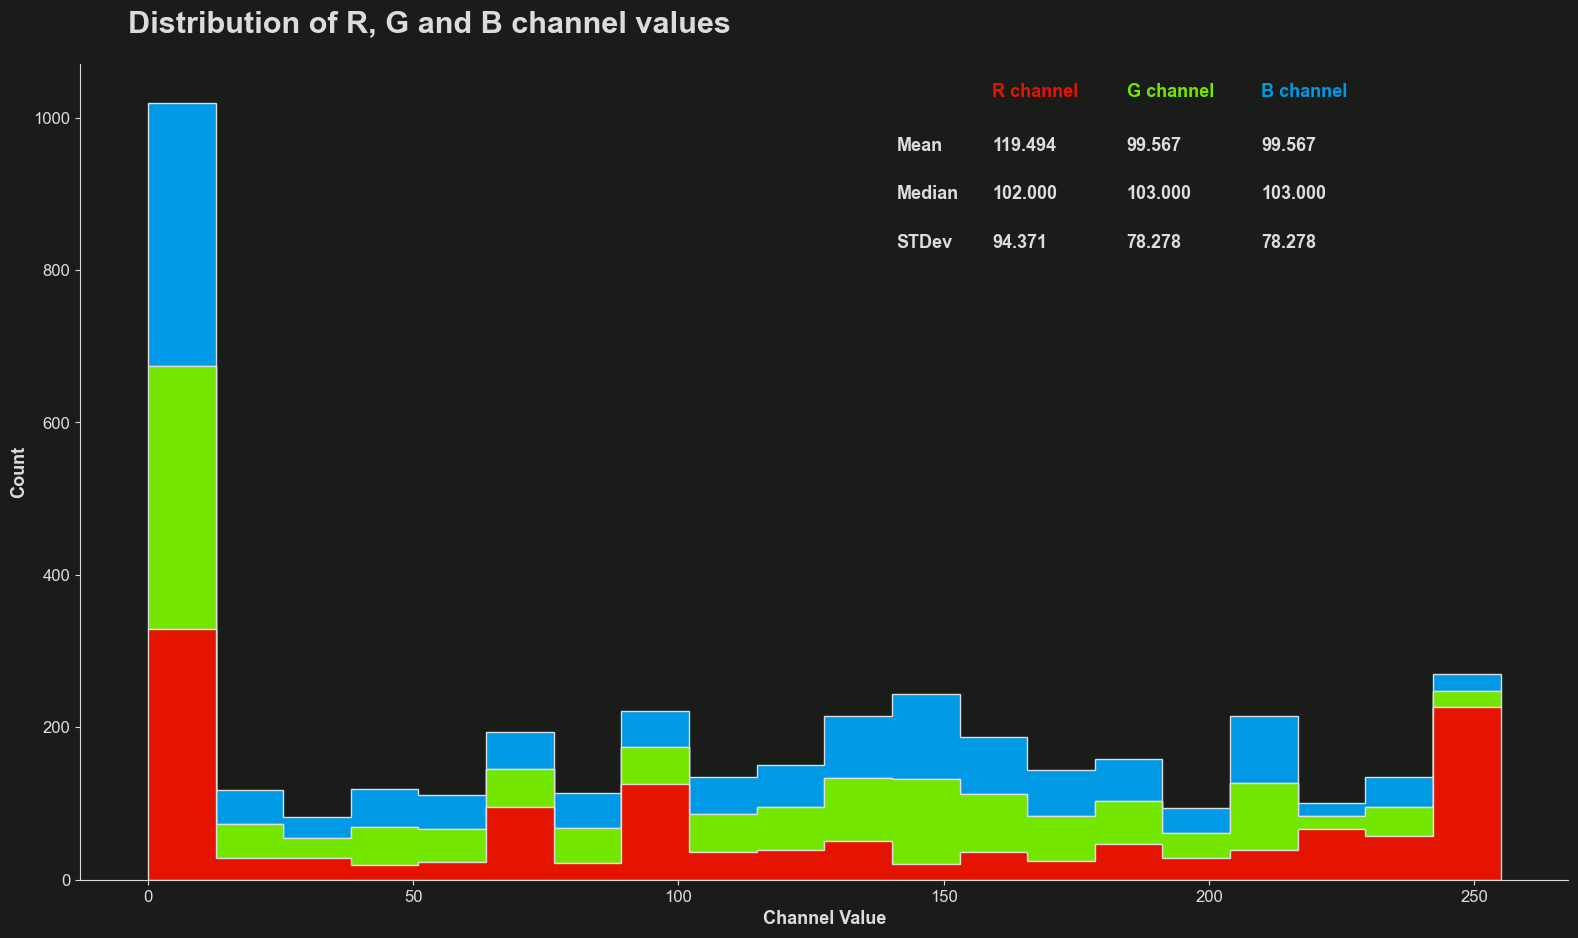

In [10]:
# --- data prep ---
datasets = [result.loc[:, colname].astype(int) for colname in ["r_value", "g_value", "b_value"]]
s_stat = {}

for dataset, label_name in zip(datasets, ["R channel", "G channel", "B channel"]):
    s_stat[label_name] = {"mean": "{:.3f}".format(dataset.mean()),
                          "median": "{:.3f}".format(dataset.median()),
                          "stdev": "{:.3f}".format(dataset.std())}
# --- viz setup ---
#create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# # configure params
# titles
plt.figtext(s="Distribution of R, G and B channel values",
          x=0.15,
          y=0.91,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# # Annotation
# Annotate column headers and row values
xloc = 0.60
yloc = 0.85
for col_header, innerDict, color in zip(s_stat.keys(), s_stat.values(), ["#E51400", "#73E600", "#0099E6"]):
    plt.figtext(s="{}".format(col_header),
        x=xloc,
        y=yloc,
        va="baseline",
        ha="left",
        fontsize=13,
        c=color,
        fontweight="bold")
    inneryloc = 0.80
    for value in innerDict.values():
        plt.figtext(s="{}".format(value),
            x=xloc,
            y=inneryloc,
            va="baseline",
            ha="left",
            fontsize=13,
            fontweight="bold")
        inneryloc -= 0.045
    xloc += 0.07
    yloc = 0.85

# Annotate row headers
xloc = 0.55
yloc = 0.80
for row_header in ["Mean", "Median", "STDev"]:
    plt.figtext(s="{}".format(row_header),
        x=xloc,
        y=yloc,
        va="baseline",
        ha="left",
        fontsize=13,
        fontweight="bold")
    yloc -= 0.045


# axis labels
ax.set_ylabel("Count",
              fontsize=13,
              fontweight="bold")

ax.set_xlabel("Channel Value",
              fontsize=13,
              fontweight="bold")

# spines and axes
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# --- plotting ---
hist = ax.hist(x=datasets,
               bins=20,
               histtype="stepfilled",
               stacked="true",
               color=["#E51400", "#73E600", "#0099E6"],
               edgecolor="#DBDDDB")

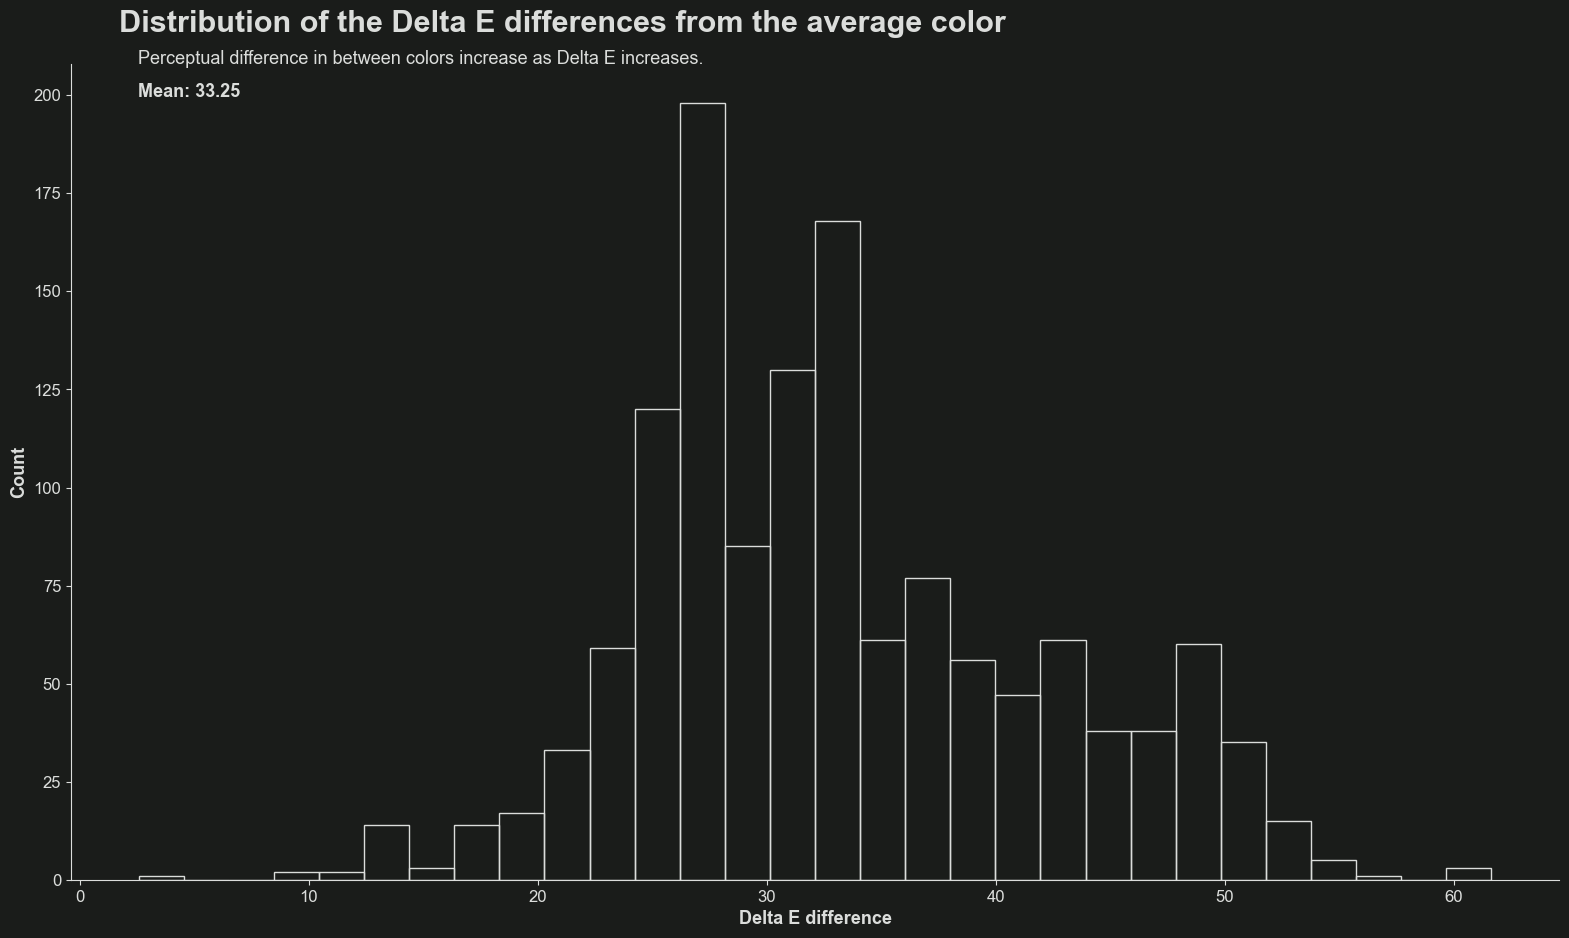

In [11]:
# --- data prep ---
data = diffs

# --- viz setup ---
#create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# # configure params
# titles
plt.figtext(s="Distribution of the Delta E differences from the average color",
          x=0.15,
          y=0.91,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

plt.figtext(s="Perceptual difference in between colors increase as Delta E increases.",
            x=0.16,
            y=0.88,
            va="baseline",
            ha="left",
            fontsize=13,
            fontweight="normal")

# # Annotation
# Annotate the mean
plt.figtext(s="Mean: {:.2f}".format(diffs.mean()),
            x=0.16,
            y=0.85,
            va="baseline",
            ha="left",
            fontsize=13,
            fontweight="bold")



# axis labels
ax.set_ylabel("Count",
              fontsize=13,
              fontweight="bold")

ax.set_xlabel("Delta E difference",
              fontsize=13,
              fontweight="bold")

# spines and axes
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# --- plotting ---
hist = ax.hist(x=data,
               bins=30,
               color="#FFFFFF00",
               histtype="bar",
               edgecolor="#DBDDDB")


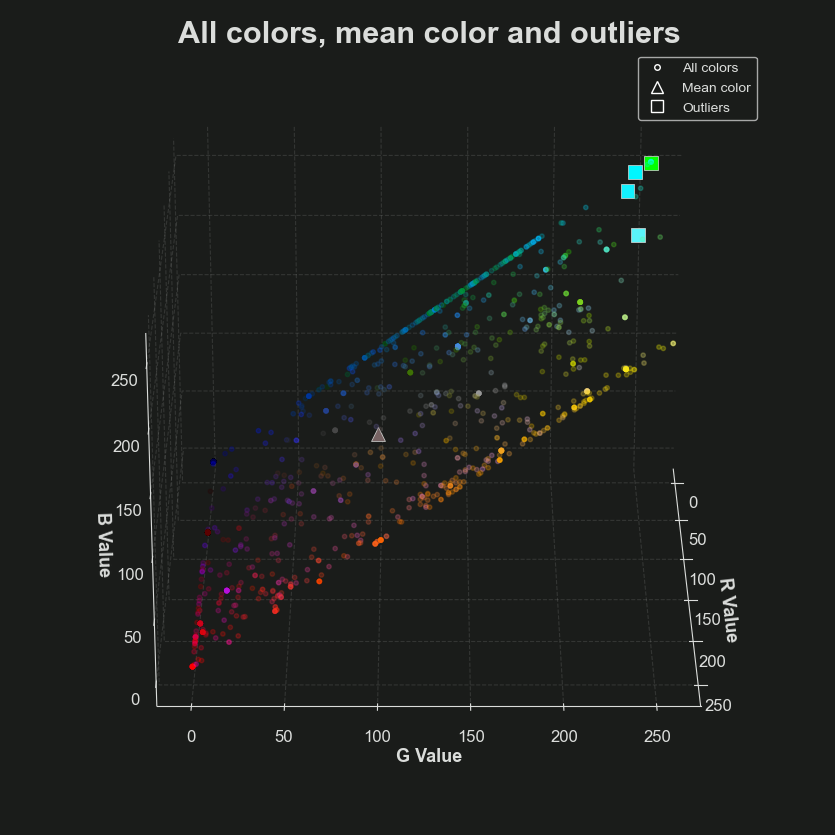

In [12]:
# --- data prep ---
data = result

# --- viz setup ---
#create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1, projection="3d")

# # configure params
# titles
plt.figtext(s="All colors, mean color and outliers",
          x=0.3875,
          y=0.85,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# axis labels
ax.set_xlabel("R Value",
              fontsize=13,
              fontweight="bold")

ax.set_ylabel("G Value",
              fontsize=13,
              fontweight="bold")

ax.set_zlabel("B Value",
              fontsize=13,
              fontweight="bold")

# Legend
legend_markers = ["o", "^", "s"]
legend_msizes = [4, 8, 8]
legend_colors = ["#FFFFFF00", "#FFFFFF00", "#FFFFFF00"]
legend_labels = ["All colors", "Mean color", "Outliers"]
patches = []
for legend_marker, legend_msize, legend_color, legend_label in zip(legend_markers, legend_msizes, legend_colors, legend_labels):
    patches.append(mlines.Line2D([], [],
                                 marker=legend_marker,
                                 color=legend_color,
                                 label=legend_label,
                                 markersize=legend_msize,
                                 markeredgecolor="white"))

ax.legend(handles=patches, loc=(0.77, 0.865), fontsize="small")


# grid, spines and axes
#Make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.yaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
ax.zaxis._axinfo["grid"]['color'] =  "#DBDDDB22"
# make the grid lines hatched
ax.xaxis._axinfo["grid"]['linestyle'] =  "--"
ax.yaxis._axinfo["grid"]['linestyle'] =  "--"
ax.zaxis._axinfo["grid"]['linestyle'] =  "--"

# 3D view
ax.view_init(elev=25., azim=0., vertical_axis="z")

# --- plotting ---
# Non-masked values
scatter1 = ax.scatter(xs=data.loc[:, "r_value"].astype(int),
                      ys=data.loc[:, "g_value"].astype(int),
                      zs=data.loc[:, "b_value"].astype(int),
                      s=10,
                      marker="o",
                      facecolors=data.loc[:,"color"],
                      alpha=0.25,
                      label="All colors")

# Avg color
scatter2 = ax.scatter(xs=avgs["r_value"],
                      ys=avgs["g_value"],
                      zs=avgs["b_value"],
                      s=100,
                      marker="^",
                      linewidths=0.5, edgecolors="#DBDDDB",
                      color=hex_avg_color,
                      alpha=1,
                      label="Mean color")

# Outliers
scatter3 = ax.scatter(xs=outlier_colors.loc[:, "r_value"].astype(int),
                      ys=outlier_colors.loc[:, "g_value"].astype(int),
                      zs=outlier_colors.loc[:, "b_value"].astype(int),
                      s=100,
                      marker="s",
                      linewidths=0.5, edgecolors="#DBDDDB",
                      color=outlier_colors.loc[:,"color"],
                      alpha=1,
                      label="Outliers")

###### Interpretation

The first figure shows the overall distribution of R, G and B values of all colors. From the mean of those three distributions we can create an "average" RGB color with the values (119, 99, 99). The second figure shows the distribution of Delta E (a measure of color difference) difference in between all colors and the calculate "average" color. Finally, the last figure has all colors including the calculated color plotted in the 3D space. The hues that are statistically furthest away from the average color (outliers) are taken as unique hues and highlighted.

#### Question nine

> ***Is there any relationship between the age of a line and its color?***

##### English explanation

###### SQL explanation

Join the 'lines' table with the 'stations' table through the 'station_lines' table. Group first by line_id, then by line age. Select line id's and line colors. Calculate the line age for each line and station combination by substracting from the current date the station opening date. Also convert the hexcode color value into separate red, green and blue values in integer format. Order by line_id in ascending, and then by line age descending.

###### Python explanation

Read the resulting SQL table into a Python dataframe. Filter the dataframe by selecting only the oldest station + line combo. This way, we effectively select the true age for each line.



##### Code

In [13]:
sql_query = """
SELECT l.id AS line_id,
       l.color AS line_color,
       CONV(SUBSTRING(l.color, 2, 2), 16, 10) AS r_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS g_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS b_value,
      (2021 - s.opening) AS age
  FROM `lines` l
        JOIN station_lines sl ON (sl.line_id = l.id)
        JOIN stations s ON (s.id = sl.station_id )
 GROUP BY line_id, age
 ORDER BY line_id ASC, age DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
max_mask = result.groupby("line_id")["age"].transform(max) == result["age"]
result = (result.loc[max_mask, :]
          .sort_values("age", ascending=False))
result.loc[:, ["r_value", "g_value", "b_value"]] = result.loc[:, ["r_value", "g_value", "b_value"]].astype(int)


##### Interpretation of results

###### Visualization

The code responsible for creating the visualization has been collapsed for ease of reading.

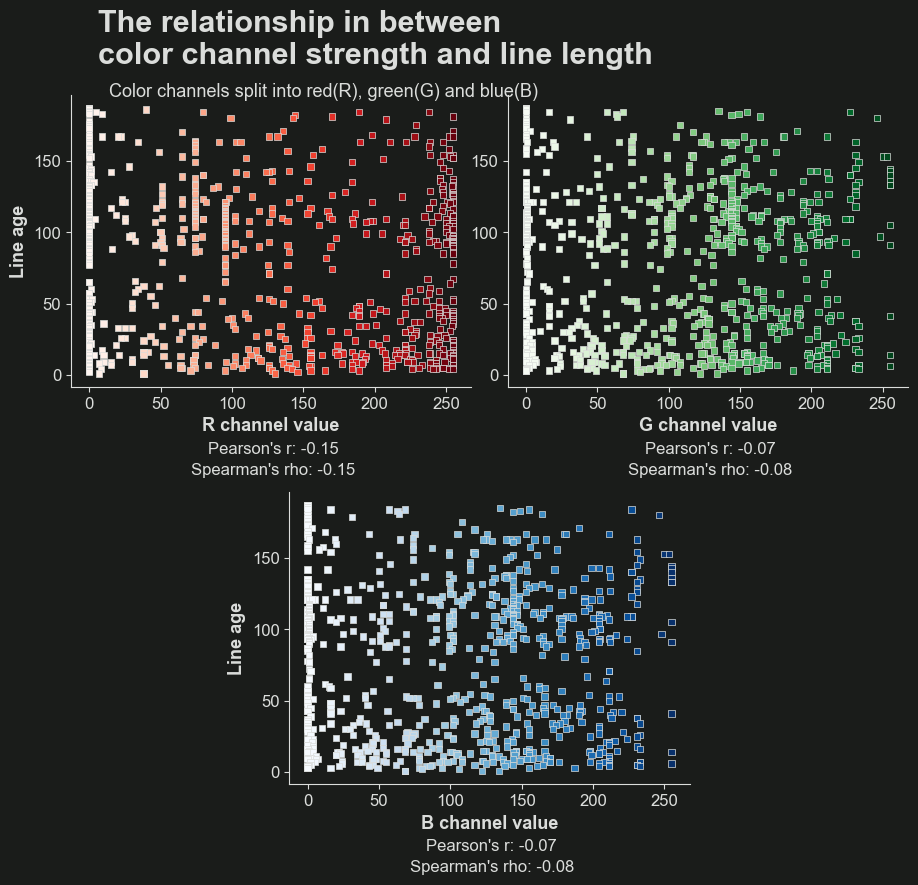

In [14]:
# --- data prep ---
data = result
datasets = [data.loc[:, [colname, "age"]].rename({colname: "colvalue"}, axis=1) for colname in ["r_value", "g_value", "b_value"]]

# get the data into a format that is more suitable for iterative plotting
fig_titles = ["R channel value", "G channel value", "B channel value"]
cmaps = ["Reds", "Greens", "Blues"]
correlations = [[dataset.corr(method="pearson") for dataset in datasets],
                 [dataset.corr(method="spearman") for dataset in datasets]]

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (10.80, 10.80),
                 dpi = 100)
spec = fig.add_gridspec(ncols=4, nrows=2, hspace=-0.05)
ax_positions = [spec[0, :2], spec[0, 2:], spec[1, 1:3]]
for ax_position in ax_positions:
    ax = fig.add_subplot(ax_position, aspect=1)


# configure params
# titles
plt.figtext(s="The relationship in between\ncolor channel strength and line length",
          x=0.15,
          y=0.85,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

plt.figtext(s="Color channels split into red(R), green(G) and blue(B)",
             x=0.16,
             y=0.82,
             va="baseline",
             ha="left",
             fontsize=13,
             fontweight="normal")

for ax, dataset, fig_title, cmap, rcorr, rhocorr in zip(fig.axes, datasets, fig_titles, cmaps, correlations[0], correlations[1]):
# spines and axes
    for spine in ["right", "top"]:
        ax.spines[spine].set_visible(False)

# axis labels

# --- plotting ---
    ax.scatter(dataset["colvalue"], dataset["age"],
               s=20, marker="s",
               linewidths=0.5, edgecolors="#DBDDDB",
               c=dataset["colvalue"], cmap=cmap)

    ax.set_xlabel(fig_title,
                  fontsize=13,
                  fontweight="bold")

    if fig_title != "G channel value":
        ax.set_ylabel("Line age",
                    fontsize=13,
                    fontweight="bold")

    ax.text(x=129, y=-55,
            s="Pearson's r: " + "{:.2f}".format(rcorr.values[0][1]),
            va="baseline",
            ha="center",
            fontweight="normal")

    ax.text(x=129, y=-70,
            s="Spearman's rho: " + "{:.2f}".format(rhocorr.values[0][1]),
            va="baseline",
            ha="center",
            fontweight="normal")

###### Interpretation

The question seeks to answer whether there is any relationship in between the age of a line and its color. While "color" can be quantified in many ways (brightness, hue, saturation) we quantify color by separating it into three channels, namely red, green and blue. This quantification is chosen because it is the most straightforward transformation of the hexcodes that the 'city-lines' dataset provides. "Relationship in between the age of a line and its color" is operationalized as linear correlation and calculated using Pearson's R. **The data visualization clearly shows that there is no linear relationship in between any of the color channels and the age of a line.** It is also apparent that there is no other relationship in between the two variables either.

#### Question ten

> ***What is the most dominant line color for each country?***

##### English explanation

###### SQL explanation
Join the cities table with the lines table. Select each country from the cities table that appears more than twice in the "lines" table. This is used to filter out countries that have less than three distinctly colored transportation lines recorded in the database. Select color of the each line to represent the lines. Group by country first, then by color. Calculate how many times each color occurs within its country group, name this as "occurence_count"

###### Python explanation
We read the SQL table we get into a dataframe. To make our dataframe more intelligible, we first convert "occurence_count" to a percentage. Then we filter the dataframe to get only the most recurring color.
In the end, we have a dataframe of countries, their most popular line color and its occurence percentage.

##### Code

In [15]:
sql_query = """
SELECT x.country, z.color, COUNT(z.color) AS occurence_count
  FROM (SELECT c.country, COUNT(c.country)
          FROM cities c
               JOIN `lines` l ON (c.id = l.city_id)
         GROUP BY c.country
         HAVING COUNT(c.country) > 2) x
        JOIN cities y ON (x.country = y.country)
        JOIN `lines` z on (y.id = z.city_id)
 GROUP BY x.country, z.color
 ORDER BY x.country ASC, occurence_count DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
perc = (result.groupby(["country"])["occurence_count"].max()
        / result.groupby(["country"])["occurence_count"].sum()*100) # Get the percentage versions
perc = pd.DataFrame(perc).reset_index()
max_mask = result.groupby("country")["occurence_count"].transform(max) == result["occurence_count"] # Select the max only
result = (result.loc[max_mask, :]
          .sort_values("country", ascending=True))
result = pd.merge(result, perc, on="country")
result = (result
          .drop("occurence_count_x", axis=1)
          .rename({"occurence_count_y": "occurence_perc"}, axis=1))

##### Interpretation of results

Visualizing the results and then interpreting them would serve the purpose of answering our question better than looking at only raw data.

###### Visualization
The code responsible for creating the visualization has been collapsed for ease of reading.

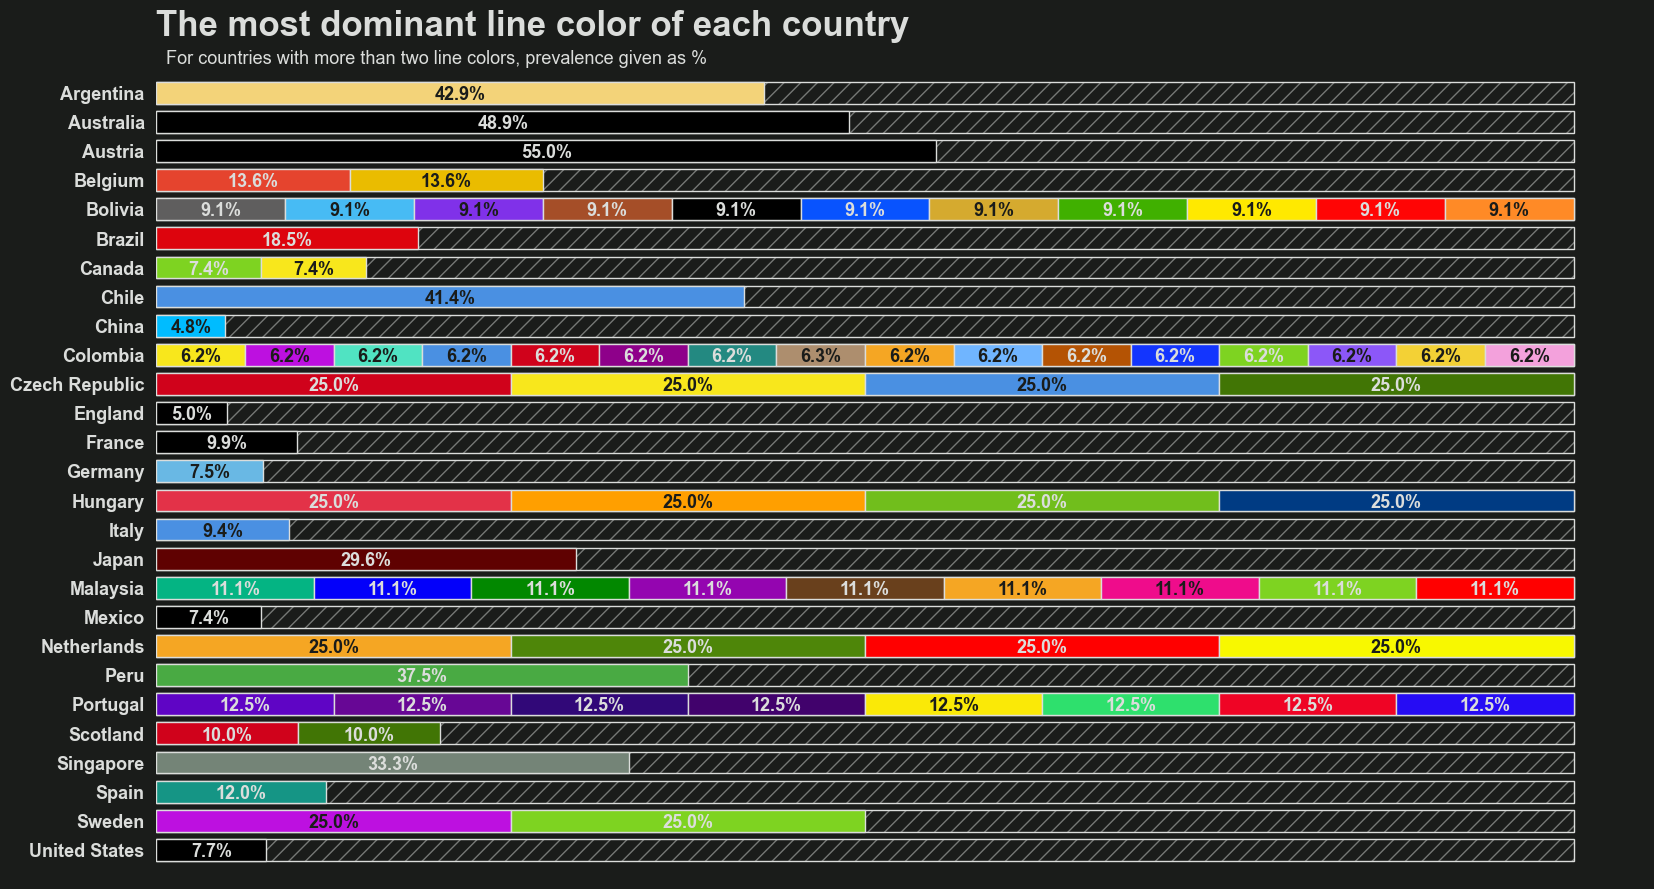

In [16]:
# --- data prep ---
data = result

# get the data into a format that is more suitable for iterative plotting
data_levels = []
data_levels.append(data)
i = 0
while sum(data_levels[i]["country"].duplicated()):
    mask = data_levels[i]["country"].duplicated()
    data_levels.append(data_levels[i].loc[mask, :])
    data_levels[i] = data_levels[i].loc[~mask, :]
    i += 1

unique_countries = sorted(set(data_levels[0]["country"].values))

# save the position of each unique country
positions = {}
i = 0
j = 0
while i < len(unique_countries):
    positions[unique_countries[i]] =  j
    j += 1
    i += 1

# prepare base plot (gray bars at 100 length) data
bar_labels = unique_countries
bar_positions = [positions[name] for name in bar_labels]
bar_widths = [100 for label in bar_labels]

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# configure params
# spines and axes
for spine in ["left", "right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.invert_yaxis()
ax.axes.set_ylim(27, -1)

# ticks and labels
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_labels,
                   fontsize=13,
                   fontweight = "bold")

ax.set_xticks([])
ax.set_xticklabels([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# --- plotting ---
# write the title 
plt.title("The most dominant line color of each country",
          fontdict={'fontsize': 25,
                   'fontweight' : "bold",
                   'verticalalignment': 'baseline',
                   'horizontalalignment': "left"},
          loc="left",
          pad=20)

plt.suptitle('For countries with more than two line colors, prevalence given as %',
             x=0.13,
             y=0.88,
             va="baseline",
             ha="left",
             fontsize=13)

# plot the base figure without hatches
ax.barh(y = bar_positions,
        width = bar_widths,
        color = "#FFFFFF00",
        hatch = "//",
        align = "center",
        height = 0.75,
        edgecolor = "#757875",
        linewidth = 0)

# plot the base figure with hatches
ax.barh(y = bar_positions,
        width = bar_widths,
        color = "#FFFFFF00",
        align = "center",
        height = 0.75,
        edgecolor = "#DBDDDB",
        linewidth = 1)

# plot the stacked bar charts iteratively
i = 0
left_widths = data_levels[0].loc[:, ["country", "occurence_perc"]]
while i < len(data_levels):
    data_level = data_levels[i]
    bar_widths = data_level["occurence_perc"].values
    bar_labels = sorted(data_level["country"].values)
    opposite_mask = left_widths.loc[:, "country"].isin(data_level["country"])

    left_start = left_widths.loc[opposite_mask, "occurence_perc"].values if i > 0 else 0

    if i > 0:
        left_widths.loc[opposite_mask, "occurence_perc"] += bar_widths

    bar_positions = [positions[name] for name in bar_labels]
    bar_colors = data_level["color"]

    bar = ax.barh(y = bar_positions,
            height = 0.75,
            width = bar_widths,
            left = left_start,
            color = bar_colors,
            align = "center",
            edgecolor = "#DBDDDB",
            linewidth = 1)

    add_value_labels_barh(ax, bar,
                          l_prefix="", l_suffix="%",
                          fontsize=13, fontweight="bold", fcolors=["#DBDDDB", "#1A1C1A"],
                          ha="center", va="center_baseline", rotation="0")
    i += 1

###### Interpretation

The visualization above displays the most dominant line color for 27 of the countries present in the 'city-lines' dataset. These 27 countries are a subset of the total countries that are represented in the dataset because only countries that have more than two distinct line colors have been included in the analysis. **In the visualization, each colored segment of the vertical bars gives information about what the dominant line color is for the country that it matches with.** The segments are annotated with the percentage by which they are dominant. The un-colored, textured portions of the vertical bars stand for the rest of the color distribution.

The first thing that is apparent from the visualization is the fact that there are many unique colors that stand as the most dominant line colors of their countries. Colors such as **red, yellow, green and black** are well-represented in the dataset. However, more unusual colors like **maroon, teal and pink are also present as 'top' colors.** The percentage by which a color stands as the most utilized line color also differs highly: the most used line colors of some countries such as China and England are popular only by 4.8% and 5.0% respectively whereas in contrast the top color of Austria is prevalent by an overwhelming 55.0%

Another occurence that is highlighted in the visualization is the fact that **not all countries have only one color as it's most dominant color.** There are many countries that have two or more colors with the same prevalence, such as Belgium (two colors), Sweden (two colors) and Colombia (16 colors.)